# Final evaluation
- This notebook will evaluate the final models' generalization capabilities. The models which have shown general better cross-validation results were **ANN**, **SVM** and **Stacking**. Both **ANN** and **Stacking** yield better results when **no dimensionality reduction** is applied. On the other hand, **feature selection** seems to be the best technique for **SVM**. All these three models will be evaluated and compared with test data.
- All data has been previously processed and normalized in the notebook `data_expl_and_preproc.ipynb`.

## Authors
- Izquierdo Alvarez, Mario
- Giménez López, Antonio
- Romero Romero, Martín
- Nunez Sánchez, Fernando 

## Enviroment configuration
- Firstly, the needed packages along with our custom Modules are loaded. Additionally, a `Random.seed()` is set for reproducibility.

In [1]:
using Random
using Statistics
# Including Modules
push!(LOAD_PATH, "./modules")

#Random seed for reproducibility
seed = 42
Random.seed!(seed);

In [19]:
using HDF5;
using Preprocessing;
using ModelSelection;
using Plotting;
using ANN_Modeling;
using Sk_Modeling
using Evaluation;

In [3]:
using Statistics;
using Flux;
using Random;

## Loading data

### No Dimensionality Reduction Data
- This data was **only** preprocessed using Min-Max normalization.

In [4]:
file = h5open("./NDR/ndr_data.h5", "r")
train_input = read(file, "train_input")
test_input = read(file, "test_input")
train_tags = read(file, "train_tags")
test_tags = read(file, "test_tags")

train_tags_oneHot = convert(BitMatrix, read(file, "train_tags_oneHot")) #For ANN
test_tags_oneHot = convert(BitMatrix, read(file, "test_tags_oneHot")) # For ANN
close(file)

In [5]:
# Parsing the tags to Integers
# Reshaping the vectors to matrices (Stacking uses matrices as inputs)
train_tags = reshape(map(x -> parse(Int, x) ,train_tags), :, 1)
test_tags =  reshape(map(x -> parse(Int, x) ,test_tags), :, 1)
size(train_input), size(test_input), size(train_tags), size(test_tags)

((1600, 20), (400, 20), (1600, 1), (400, 1))

### Feature Selection Data
- This data was preprocessed using Min-Max normalization and feature selection.
The selected features are:

    1. RAM
    2. Battery Power
    3. Screen Height
    4. Screen Width

In [7]:
file = h5open("./FSelection/fs_data.h5", "r")
fs_train_input = read(file, "train_input")
fs_test_input = read(file, "test_input")
fs_train_tags = read(file, "train_tags")
fs_test_tags = read(file, "test_tags")

train_tags_oneHot = convert(BitMatrix, read(file, "train_tags_oneHot")) #For ANN
test_tags_oneHot = convert(BitMatrix, read(file, "test_tags_oneHot")) # For ANN
close(file)

In [20]:
size(fs_train_input),size(fs_train_tags),size(fs_test_input),size(fs_test_input)

((1600, 4), (1600,), (400, 4), (400, 4))

In [12]:
# Defining labels for plotting
labels = ["Medium", "High", "Very High", "Low" ]

4-element Vector{String}:
 "Medium"
 "High"
 "Very High"
 "Low"

## Hold-Out

At the beginning of the project, we held out the 20% of the data with the purpose of using it for the final evaluation. Now that all of our models have been tested with the cross-validation technique on train data, we have selected the top three models which have demonstrated the best performance. To make an unbiased estimation of its accuracy, we will train all these models with all train data and the test dataset is going to be used for the first time. 

## Final models training and evaluation

### ANN

In [13]:
model = :ANN
hyperparameters = Dict("architecture" => [64, 32], "activation" => fill(σ, 2), "learning_rate" => 0.01, "validation_ratio" => 0.2, "n_iter_no_change" => 80,"repetitionsTraining" => 10, "max_iter" => 2000, "minLoss" => 0.0);
    
all_metrics, conf = modelHoldOut(model,
    hyperparameters,
    (train_input, train_tags_oneHot), 
    (test_input, test_tags_oneHot));

printMetricsSummary(all_metrics)


--------------- METRICS SUMMARY ---------------

----- acc -----
Mean:       0.9612
Std. Dev.:  0.0064

----- err_rate -----
Mean:       0.0388
Std. Dev.:  0.0064

----- sensitivity -----
Mean:       0.9613
Std. Dev.:  0.0064

----- specificity -----
Mean:       0.9872
Std. Dev.:  0.0022

----- ppv -----
Mean:       0.9614
Std. Dev.:  0.0064

----- npv -----
Mean:       0.9872
Std. Dev.:  0.002

----- f_score -----
Mean:       0.9612
Std. Dev.:  0.0064

----------------------------------------------


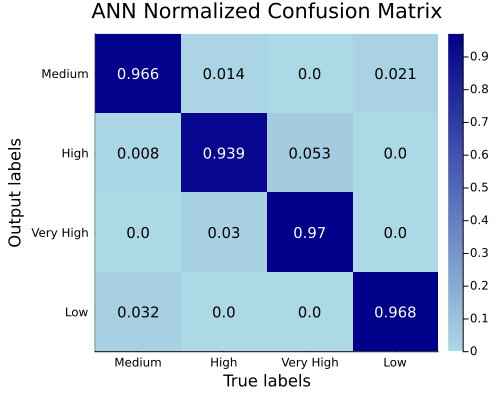

In [14]:
plotNormalizedConfusionMatrix(model, conf, labels = labels)

### ANN Discussion
The test dataset has been used with an ANN with the following hyperparameters:

    1. architecture : [64, 32] 
    2. activation : fill(σ, 2) 
    3. learning_rate : 0.01 
    5. n_iter_no_change : 80 
    6. max_iter : 2000 
    7. repetitionsTraining : 10 
    8. minLoss : 0.0


Since ANNs are stochastic models, we have repeated the experiment 10 times (`repetitionsTraining = 10`), thus getting a more reliable evaluation. 

All of this results in an accuracy of **0.9612 ± 0.0064**. Additionally, the confusion matrix can highlight some interesting information about our model: The class that yields the best results is **Very High**, whereas the one with less performance is **High**. It's also noteworthy how the confusion matrix shows that, in general, misclassifications corresponds to similar classes (i.e **Very High <---> High**, **Medium <---> High** and **Low <---> Medium**)

### Stacking

In [15]:
# Compute the inverse of the cov matrix for KNN with mahalanobis distance
cov_matrix = cov(train_input, dims=1)
inv_cov_matrix = inv(cov_matrix)

model = :Stacking
estimators = [:DecisionTree, :KNN, :ANN] # Leave out SVM
hyperparameters = [
    Dict(:max_depth => 6, :criterion => "entropy", :random_state => seed), #tree params
    Dict(:n_neighbors => 360, :metric => "mahalanobis", :metric_params => Dict("VI"=>inv_cov_matrix), :weights => "distance"), # KNN params
    Dict(:hidden_layer_sizes => (64, 32), :activation => "logistic", :learning_rate_init => 0.01, :validation_fraction => 0.2, 
        :n_iter_no_change => 80, :max_iter => 2000, :early_stopping => true, :random_state => seed), # ANN params
];

all_metrics, conf = trainClassEnsemble(estimators, 
                            hyperparameters, # TYPE CHANGED
                            (train_input, train_tags),    
                            (test_input, test_tags))
printMetricsSummary(all_metrics)


--------------- METRICS SUMMARY ---------------

-acc ==> 0.945

-err_rate ==> 0.055

-sensitivity ==> 0.945

-specificity ==> 0.9834

-ppv ==> 0.9477

-npv ==> 0.9811

-f_score ==> 0.9454

----------------------------------------------


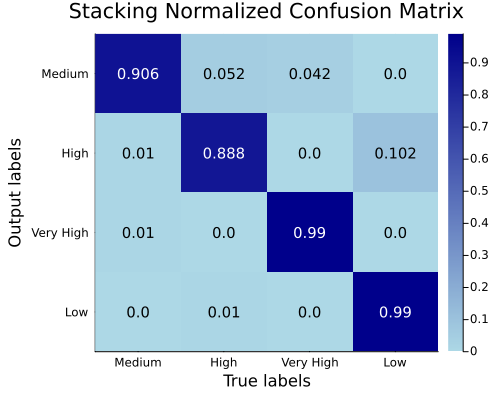

In [16]:
plotNormalizedConfusionMatrix(model, conf, labels = labels)

### Stacking Disscusion
The test dataset has been used in a Stacking with the following hyperparameters:
- **Estimators**: `[:DecisionTree, :KNN, :ANN]` (Se excluye SVM)

- **Hyperparameters**:
  - **Decision Tree**:
    - `max_depth`: 6
    - `criterion`: "entropy"
    - `random_state`: seed
  - **KNN**:
    - `n_neighbors`: 360
    - `metric`: "mahalanobis"
    - `metric_params`: `Dict("VI"=>inv_cov_matrix)`
    - `weights`: "distance"
  - **ANN**:
    - `hidden_layer_sizes`: (64, 32)
    - `activation`: "logistic"
    - `learning_rate_init`: 0.01
    - `validation_fraction`: 0.2
    - `n_iter_no_change`: 80
    - `max_iter`: 2000
    - `early_stopping`: true
    - `random_state`: seed

All of this results in an accuracy of **0.945**. Additionally, the confusion matrix can highlight some interesting information about our model: The classes that yield the best results are **Low** and **Very High**, whereas the one with less performance is also **High**. Additionaly and contrary to what we have seen in the confusion matrix of the ANN, here the misclassifications do not occur between adjacent classes. (i.e Most misclassifications labeled as **High** are indeed **Low**)

### SVM

In [17]:
model = :SVM
hyperparameters = Dict(:kernel => "linear", :C => 8, :random_state => seed);
    
all_metrics, conf = modelHoldOut(model,
    hyperparameters,
    (fs_train_input, fs_train_tags), 
    (fs_test_input, fs_test_tags));

printMetricsSummary(all_metrics)


--------------- METRICS SUMMARY ---------------

-acc ==> 0.96

-err_rate ==> 0.04

-sensitivity ==> 0.96

-specificity ==> 0.9874

-ppv ==> 0.9607

-npv ==> 0.9864

-f_score ==> 0.9601

----------------------------------------------


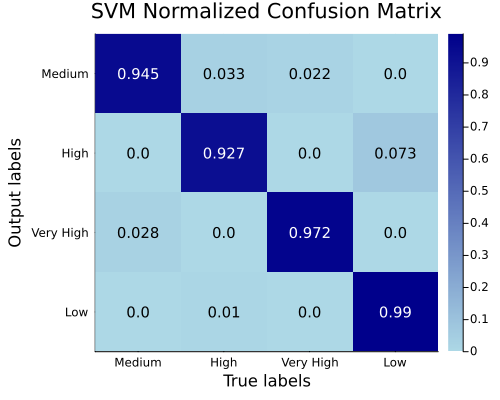

In [18]:
plotNormalizedConfusionMatrix(model, conf, labels = labels)

## SVM Discussion

The test dataset has been used with a SVM with the following hyperparameters:

    1. kernel : "linear"
    2. C : 8

All of this results in an accuracy of **0.96**. Additionally, the confusion matrix can highlight some interesting information about our model: The class that yields the best results is **Low**, whereas the one with less performance is also **High**.
Similarly to what happened in the case of the SVM, we can see in the confusion matrix how the incorrect classifications are not between similar classes, as was the case in the ANN.

## Final discussion

|                |   Stacking   |         ANN          |   SVM    |
|----------------|----------|------|------|
| Accuracy in Test |   0.945     | **0.9612 ± 0.0064** |   0.96    |



As a final conclusion to the evaluation of these three models, we can observe that they offer **very similar performance** with **quite high accuracy rates**, denoting a good generalization ability. It is noted that the model that slightly excels above the others is the **ANN**, however, this difference does not seem significant in terms of accuracy. Nevertheless, it is noteworthy how the errors of the ANN are less significant since the incorrect predictions are classified as **adjacent classes**, meaning very similar ones. In the problem domain, this detail can be important, as a difference of only one category in the price range (i.e., High and Very High) may not be very important, whereas a more noticeable difference (i.e., Low and High) would be.
